# Introduction

In [3]:
import warnings
warnings.filterwarnings("ignore")
from ipypublish.scripts.ipynb_latex_setup import *
from IPython.display import display, Image, IFrame
import pymatgen as pym
import ipywidgets as widgets
import ipyvolume as ivol
import ipyvolume.pylab as p3
from jsonextended import edict, plugins
errors = plugins.load_builtin_plugins()
import atom_visual as avis
import jsonplugins as jplugins

In [4]:
my_data = edict.LazyLoad('data/')

With the improvements in Jupyter Notebook, allowing for the synergy of browser-side javascript and client-side python coding, it is becoming possible to replicate the functionality of standalone atomic visualisation packages (such as [ovito](https://ovito.org/index.php/about)). The added benefits this approach brings is:

- Greater control and flexibility in the analysis and visualisation process 
- Fully autonomous replication of the analysis and visualisation
- Better documentation of the analysis and visualisation

The goal of this notebook is to show a method for:

1. reading/creating atomic configurations
2. visualising these in a Jupyter Notebook
3. Adding dynamic controls 
4. Overlaying electronic level data (probability/spin densities)
5. Distributing the output

The notebook and code used for this demonstration can be found [here](https://github.com/chrisjsewell/chrisjsewell.github.io/tree/master/3d_atomic).

# A Quick Introduction to JSON

A recommended practice for structuring hierarchical data (which will be used throughout this demonstration) is to use the JSON format because it is:

- applicable for any (non-relational) data structure
- lightweight and easy to read and edit
- has a simple read/write mapping to python objects
- widely used (especially in web technologies)

A good example of how this structure can being applied to quantum chamical data can be found [here](https://github.com/MolSSI/QC_JSON_Schema) and, in fact, this Jupyter Notebook itself is stored in JSON format:

In [6]:
from jsonextended import ejson, edict
jstruct = ejson.to_dict('3D Atomic Visualisation.ipynb')
edict.pprint(jstruct,depth=1)

cells:          [...]
metadata:       {...}
nbformat:       4
nbformat_minor: 2


Note that Python has a built-in `json` package, but we shall use the [jsonextended](https://github.com/chrisjsewell/jsonextended) package, which has extended functionality for data parsing, manipulation and visualisation.

## JSON Schema

Rather than strictly controlling the entire data structure from the outset, before acting on the data, we can simply validate that it contains the required data keys and types required. This is in keeping with the interpreted (as opposed to declarative) nature of Python.

Another advantage of json is that we can utilise the standard [json schema](http://json-schema.org/) approach to achieve this validation. For example, a basic Jupyter Notebook schema would look like this:

In [14]:
from jsonschema import validate
cells_schema = {
    'type':'array',
    'items':{
      'type':'object',
      'required':['cell_type'],
      'properties':{
        'cell_type':{
         'type':'string',
         'enum':["code","markdown"]
    }}}}
schema = {'type':'object',
          'required':['cells','metadata'],
          'properties':{'cells':cells_schema}}
edict.pprint(schema,depth=None, keycolor='blue')

properties: 
  cells: 
    items: 
      properties: 
        cell_type: 
          enum: [code, markdown]
          type: string
      required: [cell_type]
      type: object
    type: array
required: [cells, metadata]
type: object


JSON Schema basics are outlined [here](https://spacetelescope.github.io/understanding-json-schema/basics.html) and a cheat sheet of standard keys can be found [here](http://forivall.com/json-schema-cheatsheet/).

In [25]:
validate(jstruct, schema)
try:
    validate({'metadata':{},
              'cells':[{'cell_type':'a'}]}, 
             schema)
except Exception as err:
    print(err)

'a' is not one of ['code', 'markdown']

Failed validating 'enum' in schema['properties']['cells']['items']['properties']['cell_type']:
    {'enum': ['code', 'markdown'], 'type': 'string'}

On instance['cells'][0]['cell_type']:
    'a'


# Creating Atomic Configurations

The [pymatgen](http://pymatgen.org/) package offers a means to create/manipulate atomic configurations with repeating boundary conditions. For this demonstration, we would like to select structures from a folder of cif (crystallographic information files). This is achieved by writing a *plugin* for [jsonextended](https://github.com/chrisjsewell/jsonextended).

In [13]:
from jsonplugins import CIFPlugin
plugins.load_plugin_classes([CIFPlugin],'parsers')
edict.pprint(my_data.cif_files, depth=1)

FeS_greigite.cif: {...}
FeS_mackinawite.cif: {...}
FeS_marcasite.cif: {...}
FeS_pyrite.cif: {...}
FeS_pyrrhotite_4C_c2c.cif: {...}
FeS_troilite.cif: {...}
Fe_bcc.cif: {...}
S_8alpha_fddd.cif: {...}
S_8beta_p21c.cif: {...}


For each cif, we can now access a pymatgen structure:

In [5]:
pymstruct = my_data.cif_files.Fe_bcc_cif.structure
pymstruct

Structure Summary
Lattice
    abc : 2.4820288072462011 2.4820288072462011 2.4820288072462011
 angles : 109.47122063449069 109.47122063449069 109.47122063449069
 volume : 11.770598948
      A : -1.4329999999999996 -1.4330000000000001 1.4329999999999998
      B : -1.4330000000000001 1.4330000000000001 -1.4330000000000001
      C : 1.4330000000000001 -1.4330000000000001 -1.4330000000000001
PeriodicSite: Fe (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

Note that the underlying structure of the pymatgen structure is JSON.

In [9]:
edict.pprint(pymstruct.as_dict(),depth=None,
             round_floats=3,max_width=40,
             keycolor='blue')

@class: Structure
@module: pymatgen.core.structure
lattice: 
  a: 2.48
  alpha: 109.0
  b: 2.48
  beta: 109.0
  c: 2.48
  gamma: 109.0
  matrix: [[-1.43, -1.43, 1.43], [-1.43, 
          1.43, -1.43], [1.43, -1.43, 
          -1.43]]
  volume: 11.8
sites: 
  - abc: [0.0, 0.0, 0.0]
    label: Fe
    species: 
      - element: Fe
        occu: 1
    xyz: [0.0, 0.0, 0.0]


# Preparation for visualisation

A visualisation requires the configuration to contain some additional information, 
including the atom shape (e.g. sphere radius) and texture (e.g. sphere color). Therefore, it will be helpful to create a view agnostic data structure (i.e. independendant of any specific graphics package) of all elements we wish to visualise. The key aspects of our structure is:

1. **elements**: A list of elements in the scene. For now we only have one type but more will be added later.
2. **transforms**: A list of geometric transforms we will apply globally (to all elements) and locally (to individual elements) before visualisation.

We shall create a number of elements and transforms (and associated validation schema) for this demonstration, but any number can be specified.

In [20]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstruct = avis.struct_to_visual(struct,'mackinawite')
edict.pprint(vstruct,
    max_width=67,keycolor='blue',round_floats=3)

elements: 
  - cell_vectors: 
      a: [3.67, 0.0, 2.25e-16]
      b: [-2.25e-16, 3.67, 2.25e-16]
      c: [0.0, 0.0, 5.03]
    centre: [1.84, 1.84, 2.52]
    color: #e06633
    coords: [[0.0, 0.0, 0.0], [1.84, 1.84, 2.25e-16]]
    label: Fe
    radius: 1.32
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
  - cell_vectors: 
      a: [3.67, 0.0, 2.25e-16]
      b: [-2.25e-16, 3.67, 2.25e-16]
      c: [0.0, 0.0, 5.03]
    centre: [1.84, 1.84, 2.52]
    color: #b2b200
    coords: [[-1.12e-16, 1.84, 1.31], [1.84, 0.0, 3.72]]
    label: S
    radius: 1.05
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
transforms: []


To create the repeat cells, we have deconstructed the pymatgen structure and applied a mapping of atomic number to radius/color, using a pre-constructed csv table (\cref{tbl:atom_map}).

In [26]:
amap = avis.get_atom_map()
amap.head(3).round(2).drop(['MaxBnd','ARENeg'],axis=1)

,Blue,ElAffinity,ElNeg,Green,Ionization,Mass,Name,RBO,RCov,RVdW,Red,Symbol
,,,,,,,,,,,,
1,0.75,0.75,2.20,0.75,13.60,1.01,Hydrogen,0.31,0.31,1.10,0.75,H
2,1.00,0.00,0.00,1.00,24.59,4.00,Helium,0.28,0.28,1.40,0.85,He
3,1.00,0.62,0.98,0.50,5.39,6.94,Lithium,1.28,1.28,1.81,0.80,Li


We have grouped the atoms with the similar visual representations, rather than specifying each atom separately for simplicity. Here we do this by atomic number, but equally it could be done by symmetry equivalence or another metric.

## Geometric Transforms

Geometric transforms which we likely want to perform include:

- creating a supercell of the configuration 
- orientating the configuration in a convenient manner in the cartesian coordinate space
- slicing into the configuration

In [33]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstruct = avis.struct_to_visual(struct,'mackinawite')
avis.add_transform_align(vstruct,'b')
avis.add_transform_repeat(vstruct,'a',2)
avis.add_transform_recentre(vstruct)
avis.add_transform_slice(vstruct,(0,0,1),ubound=1.)

edict.pprint(edict.filter_keys(vstruct,['transforms']),
    max_width=67,keycolor='blue',round_floats=3)

elements: 
  - transforms: []
  - transforms: []
transforms: 
  - cvector: b
    direction: (1, 0, 0)
    type: local_align
  - cvector: a
    recentre: True
    rep: 2
    type: local_repeat
  - centre: (0.0, 0.0, 0.0)
    type: recentre
  - centre: None
    lbound: None
    normal: (0, 0, 1)
    type: slice
    ubound: 1.0


Note we haven't actually performed any of these transforms yet. This is done done by creating a transformed copy of the data at visualisation time.

In [35]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstruct = avis.struct_to_visual(struct,'mackinawite')
avis.add_transform_align(vstruct,'c',(0,0,1))
avis.add_transform_repeat(vstruct,'a',3)
avis.add_transform_repeat(vstruct,'b',3)
avis.add_transform_repeat(vstruct,'c',3)
avis.add_transform_recentre(vstruct)
avis.add_transform_slice(vstruct,(0,0,1),ubound=-4)

newstruct = avis.apply_transforms(vstruct)
edict.pprint(newstruct,compress_lists=3,
    max_width=None,keycolor='blue',round_floats=3)

elements: 
  - cell_vectors: 
      a: [14.7, 0.0, 9e-16]
      b: [-9e-16, 14.7, 9e-16]
      c: [0.0, 0.0, 20.1]
    centre: [0.0, 0.0, 0.0]
    color: #e06633
    coords: [[-7.35, -7.35, -10.1], [-5.51, -5.51, -10.1], [-3.67, -7.35, -10.1], ...(x61)]
    label: Fe
    radius: 1.32
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
  - cell_vectors: 
      a: [14.7, 0.0, 9e-16]
      b: [-9e-16, 14.7, 9e-16]
      c: [0.0, 0.0, 20.1]
    centre: [0.0, 0.0, 0.0]
    color: #b2b200
    coords: [[-7.35, -5.51, -8.76], [-5.51, -7.35, -6.34], [-3.67, -5.51, -8.76], ...(x29)]
    label: S
    radius: 1.05
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
transforms: []


# Visualising in the Jupyter Notebook

To create 3D renderings of the configuration, we will use [ipyvolume](http://ipyvolume.readthedocs.io) and its implementation of the model/view pattern.

In [44]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstruct = avis.struct_to_visual(struct,'mackinawite')
avis.add_transform_align(vstruct,'c',(0,0,1))
avis.add_transform_repeat(vstruct,'a',3)
avis.add_transform_repeat(vstruct,'b',3)
avis.add_transform_repeat(vstruct,'c',3)
avis.add_transform_recentre(vstruct)
avis.add_transform_slice(vstruct,(0,0,1),ubound=-4)

newstruct, fig, controls1 = avis.create_ivol(vstruct)
gui = widgets.VBox([fig,controls1['view'][0]])
gui

A Jupyter Widget

The rendering can also be captured as a screenshot or saved as an image/html. We shall discuss in [a later section](#Publishing-and-Distributing-Analysis) how this can be utilised to distribute the analysis.

In [37]:
image = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example1.html',[gui],
        template_options={"embed_url":'embed.js'})

A Jupyter Widget

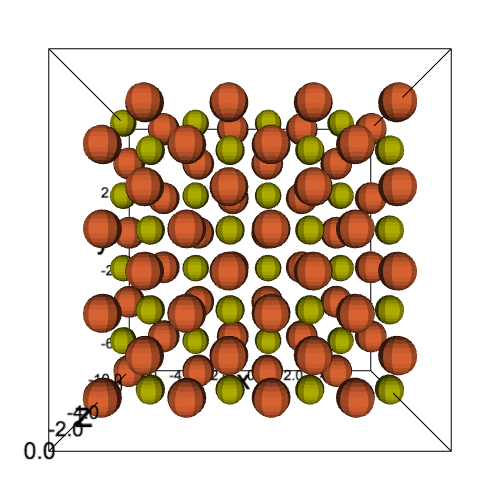

In [38]:
display(image,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example1.html',
    "other_files":["data/embed.js","data/ipyvolume.js"]}}})

# Adding Dynamic Controls

[ipyvolume](http://ipyvolume.readthedocs.io) utilises the [ipywidgets](http://ipywidgets.readthedocs.io) framework and thus it is relatively trivial to set up dynamic controls.

In [46]:
fov_widget = widgets.FloatSlider(min=1,max=90,description='Field of View')
widgets.jslink((fig, 'camera_fov'), (fov_widget, 'value'))
fov_widget

A Jupyter Widget

We can bundle these in with the original container to create a bespoke GUI.

In [47]:
cntrls = controls1
cntrls['view'].append(fov)
for el in newstruct['elements']:
    cntrl1 = avis.create_ivol_control(el,'size',
                        'FloatSlider','value',min=0,max=10,
                        description='{} Size'.format(el['label']))
    cntrl2 = avis.create_ivol_control(el,'color',
                        'ColorPicker','value',
                        description='{} Color'.format(el['label']))
    if not el['sname'] in cntrls:
        cntrls[el['sname']] = [] 
    cntrls[el['sname']].append([cntrl1,cntrl2])

new_gui = avis.add_controls(fig,cntrls,top=True) 
new_gui

A Jupyter Widget

In [50]:
image2 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example2.html',
    [new_gui],template_options={"embed_url":'embed.js'})

A Jupyter Widget

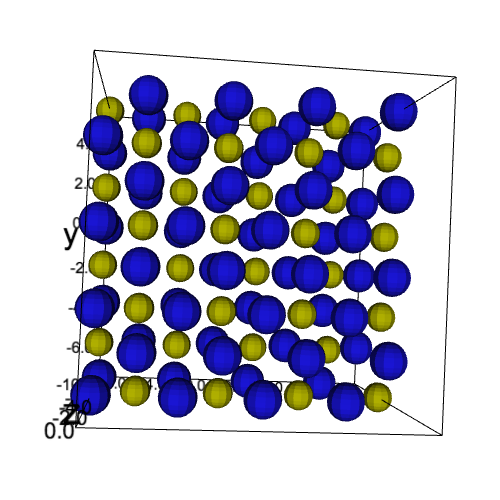

In [51]:
display(image2,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example2.html',
    "other_files":["data/embed.js","data/ipyvolume.js"],
     "height":0.45}}})

# Coordination

In [3]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
cstruct = avis.struct_to_visual(struct,'mackinawite')

main = cstruct['elements'][0]
coordinating = cstruct['elements'][1]
coord = avis.coord_to_visual(
                main, coordinating)
cstruct['elements'].append(coord)
avis.add_transform_align(cstruct,'b')
avis.add_transform_repeat(cstruct,'a',2)
avis.add_transform_repeat(cstruct,'b',2)
avis.add_transform_repeat(cstruct,'c',2)
avis.add_transform_recentre(cstruct)
avis.add_transform_slice(cstruct,(0,0,1),ubound=1.)
new_cstruct = avis.apply_transforms(cstruct)
edict.pprint(new_cstruct,compress_lists=4,
    max_width=67,keycolor='blue',round_floats=3)

elements: 
  - cell_vectors: 
      a: [-6.75e-16, -11.0, -1.48e-31]
      b: [11.0, -4.13e-32, -1.48e-31]
      c: [9.25e-16, -9.25e-16, 15.1]
    centre: [0.0, 0.0, 0.0]
    color: #e06633
    coords: [[-5.51, 5.51, -7.55], [-3.67, 3.67, -7.55], [-5.51, 
            1.84, -7.55], [-3.67, 8.88e-16, -7.55], ...(x32)]
    label: Fe
    radius: 1.32
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
  - cell_vectors: 
      a: [-6.75e-16, -11.0, -1.48e-31]
      b: [11.0, -4.13e-32, -1.48e-31]
      c: [9.25e-16, -9.25e-16, 15.1]
    centre: [0.0, 0.0, 0.0]
    color: #b2b200
    coords: [[-3.67, 5.51, -6.24], [-5.51, 3.67, -3.83], [-3.67, 
            1.84, -6.24], [-5.51, 0.0, -3.83], ...(x23)]
    label: S
    radius: 1.05
    sname: mackinawite
    transforms: []
    transparency: 1.0
    type: repeat_cell
  - cell_vectors: 
      a: [-6.75e-16, -11.0, -1.48e-31]
      b: [11.0, -4.13e-32, -1.48e-31]
      c: [9.25e-16, -9.25e-16, 15.1]
    centre: 

In [4]:
#cstruct['elements'].pop(0)
#cstruct['elements'].pop(0)
new_cstruct, fig, controls1 = avis.create_ivol(cstruct)
gui = widgets.VBox([fig,controls1['view'][0]])
gui

A Jupyter Widget

# Overlaying electronic level data

*Ab initio* quantum simulation packages can compute electronic/spin densities (to accompany the nuclei positions) in the form of a discretized 3D cube. These can be overlayed onto the nuclei, by [volume rendering](https://en.wikipedia.org/wiki/Volume_rendering) or [isosurface](https://en.wikipedia.org/wiki/Isosurface) methods. 

## Data Parsing

Taking the [CRYSTAL](http://www.crystal.unito.it/index.php) program as an example, output from the electronic density is principally output into two files; one that contains the lattice vectors and nuclei coordinates and one that contains a data cube of the electronic density, with axis relating to the cell vectors. We can write parser plugins for both these files:

In [3]:
plugins.load_plugin_classes([jplugins.ECH3OutPlugin,jplugins.ECH3CubePlugin],'parsers')
edict.pprint(my_data.crystal,keycolor='blue')

ech3.out: 
  structure: Full Formula (Si2)
             Reduced Formula: Si
             abc   :   3.832519   3.832519   3.832519
             angles:  60.000000  60.000000  60.000000
             Sites (2)
               #  SP           a         b         c
             ---  ----  --------  --------  --------
               0  Si    0.125092  0.125092  0.125092
               1  Si    0.874908  0.875277  0.874908
ech3_dat.prop3d: 
  charge_density: np.array((100, 100, 100), min=2.68E-03, max=5.36E+02)
  da_vec: [ 0. 0.051729 0.051729]
  db_vec: [ 0.051729 0. 0.051729]
  dc_vec: [ 0.051729 0.051729 0. ]
  na:    100
  nb:    100
  nc:    100
  o_vec: [0.0, 0.0, 0.0]


## Visualisation Preparation

We then, follow the same process as for atoms; converting to a common structure and adding geometric transforms. Note that we apply the slices locally, so that we can first resize the density array. We do this because, after the `repeat` transforms, the array size is now; (400,400,400), which would be costly to compute the slice for. Resizing by 0.25 reduces the array back to (100,100,100).

In [60]:
nuclei = avis.struct_to_visual(my_data.crystal.ech3_out['structure'],'Silicon')
avis.add_transform_slice(nuclei['elements'][0],(0,1,1),lbound=-2,ubound=0)

electrons = avis.dcube_to_visual(my_data.crystal.ech3_dat_prop3d['charge_density'],
                            my_data.crystal.ech3_out['structure'],
                            'Silicon','charge density')
avis.add_transform_resize(electrons['elements'][0],.25)
avis.add_transform_slice(electrons['elements'][0],(0,1,1),lbound=-2,ubound=0)

dstructs = edict.merge([nuclei,electrons],append=True)

avis.add_transform_repeat(dstructs,'a',3)
avis.add_transform_repeat(dstructs,'b',3)
avis.add_transform_repeat(dstructs,'c',3)
avis.add_transform_recentre(dstructs,(0,0,0))
edict.pprint(edict.filter_keys(dstructs,['type','sfraction','rep']),keycolor="blue",round_floats=3)

elements: 
  - transforms: 
      - type: slice
    type: repeat_cell
  - transforms: 
      - sfraction: 0.25
        type: resize
      - type: slice
    type: repeat_density
transforms: 
  - rep: 3
    type: local_repeat
  - rep: 3
    type: local_repeat
  - rep: 3
    type: local_repeat
  - type: recentre


## Visualisation

Before parsing to ipyvolume, we use the cell vectors to transform the data cube into cartesian coordinates, such that voxels (cube sections) outside of the cell volume are set as np.nan values. In the example, we have thus created a really nice representation of the covalent bonding in bulk silicon crystals.

In [63]:
newstruct, fig2, controls2 = avis.create_ivol(dstructs,
                data_min=1.6,data_max=2,ssize=3,
                level=[.5, .25, .1],opacity=[.2,.15,.05])
fov_widget = widgets.FloatSlider(min=1,max=90,description='Field of View')
widgets.jslink((fig2, 'camera_fov'), (fov_widget, 'value'))
controls2['view'].append(fov_widget)
cntrl1 = avis.create_ivol_control(
    newstruct['elements'][0],'size',
    'FloatSlider','value',
     min=0, max=10,
     description='Size')
cntrl2 = avis.create_ivol_control(
    newstruct['elements'][0],'color',
    'ColorPicker','value',
     description='Color')
controls2['Nucleii'] = [cntrl1,cntrl2]
volgui = avis.add_controls(fig2,controls2)
volgui

A Jupyter Widget

In [64]:
image3 = p3.screenshot(width=500, height=500)
ivol.embed.embed_html('data/ivol_example3.html',
[volgui],template_options={"embed_url":'embed.js'})

A Jupyter Widget

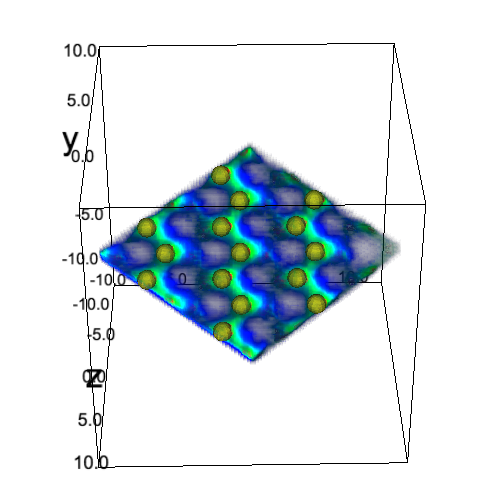

In [65]:
display(image3,metadata={'ipub':{'embed_html':{
    "filepath":'data/ivol_example3.html',
    "other_files":["data/embed.js","data/ipyvolume.js"],
    "height":0.5}}})

# 2D Representations

Because the data is stored in a representation agnostic manner, this allows for the possibility of displaying the data in multiple ways. In particular, for publication quality images we may want to create a 2D-representation of the scene. Below we plot the atoms with a depth perception effect, created by lightening the color of the atoms w.r.t their depth into the page.

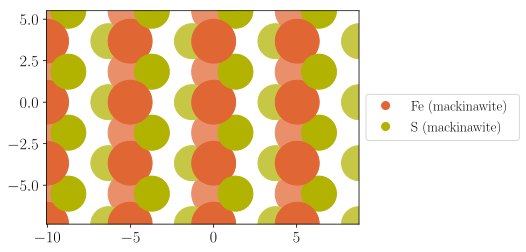

In [66]:
struct = my_data.cif_files.FeS_mackinawite_cif.structure
vstruct = avis.struct_to_visual(struct,'mackinawite')
avis.add_transform_align(vstruct,'c')
avis.add_transform_repeat(vstruct,'a',3)
avis.add_transform_repeat(vstruct,'b',3)
avis.add_transform_repeat(vstruct,'c',3)
avis.add_transform_recentre(vstruct)
avis.plot_atoms_top(vstruct,color_depth=6);

#  Publishing and Distributing Analysis

As discussed above, individual visualisations can be saved individually as images or HTML. But a more complete solution is to use [ipypublish](https://github.com/chrisjsewell/ipypublish) to convert the entire Jupyter Notebook to a document and/or presentation. ipypublish utilises notebook/cell/output level metadata attributes to define a greater level of control as to how elements in the notebook are converted.  

This entire document is a single notebook which is available as a [Notebook](https://github.com/chrisjsewell/chrisjsewell.github.io/blob/master/3d_atomic/3D%20Atomic%20Visualisation.ipynb), [PDF](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.view_pdf.html), [HTML](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.html) or [Reveal.JS slideshow](https://chrisjsewell.github.io/3d_atomic/converted/3D%20Atomic%20Visualisation.slides.html) document (click the hyperlinks to view them). This was achieved by only the following command line commands: 

```
$ nbpublish -pdf -ptemp -f latex_ipypublish_nocode "3D Atomic Visualisation.ipynb"
$ nbpublish -f html_ipypublish_all "3D Atomic Visualisation.ipynb"
$ nbpresent "3D Atomic Visualisation.ipynb"
```

# TODO

- Orthographic camera. Not yet implemented in ipyvolume, see [this issue](https://github.com/maartenbreddels/ipyvolume/issues/31) for current status.
- better control of spheres
    - exact control of radii (radius rather than scaling size)
    - more segments (either direct control of segments, or a "sphere_hi_res" type)
    - transparency level
    - should color allow (r,g,b) tuple/array?
    because at the moment that doesn't work
- creation of array of arbitrary lines (like scatter but with; x0,y0,z0,x1,y1,z1)
    - show lattice bounding boxes: parallelepiped wire frames 
    - show bonds (i.e. connections) between different scatters
- show nearest-neighbour coordination: polygons with vertices at nearest-neighbour positions (as shown in \cref{fig:nnpolygons})

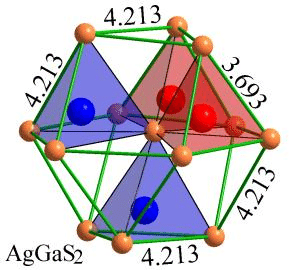

In [42]:
display(Image('data/nn_coordination.jpg',width=200),
        metadata={"ipub":{
      "figure":{
         "caption":"an example of nearest-neighbour polygons",
         "label":"fig:nnpolygons",
         "height":0.2}}})

- functional (browser side) controls, e.g. slider to translate/rotate point set. Not yet implemented in ipywidgets, see [this issue](https://github.com/jupyter-widgets/ipywidgets/issues/1109) for current status.
- volumes:
    - RuntimeWarning: invalid value encountered in true_divide 
    (serialize.py:43) presumably for (0,0,0) gradients
    - rarely get artifact rendering
    - isosurface rendering
    - multiple volumes in single plot
    - volumes with arbitrary centres
    - rotating volumes
- fullscreen
    - fails to open if multiple views instantiated
    - if volume is present,
    then the rendering becomes very low resolution
    and, sometimes, the volume disappears completely on exit
- 2d volume representation
    - define slice into cube and use matplotlib.contour